https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download


# Read Data

In [ ]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)

from src.recommend.utils.read import read_files

folder_path = "./data/kaggle_movies"
dataframes = read_files(folder_path)

credits = dataframes['credits']
keywords = dataframes['keywords']
links = dataframes['links']
links_small = dataframes['links_small']
movies_metadata = dataframes['movies_metadata']
ratings = dataframes['ratings']
ratings_small = dataframes['ratings_small']

c:\Users\JaeHoBahng\Desktop\US_Job\Portfolio\Recommendation\movielens\src\recommend\utils\read.py:12: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[df_name] = pd.read_csv(file_path)


# Clean Data

In [2]:
# Merge metadata with linked IDs
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')
merged_df = movies_metadata.merge(links, left_on='id', right_on='tmdbId', how='left')
merged_df = merged_df[~merged_df['id'].isnull()]

# Images
https://api.movieposterdb.com/docs/#docs/method/#1480

In [3]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt

def image_url(movie_list):
    images = []
    for id in movie_list:
        url = f'http://img.omdbapi.com/?i={id}&apikey=49b60587'
        response = requests.get(url)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            images.append(img)
        else:
            print(f"Failed to retrieve image from {url}")
    return images

def show_image(image_list):
    # Plot images side by side
    fig, axes = plt.subplots(1, len(image_list), figsize=(15, 5))

    # If only one image, axes is not iterable
    if len(image_list) == 1:
        axes = [axes]

    for ax, img in zip(axes, image_list):
        ax.imshow(img)
        ax.axis("off")  # Hide axes

    plt.show()

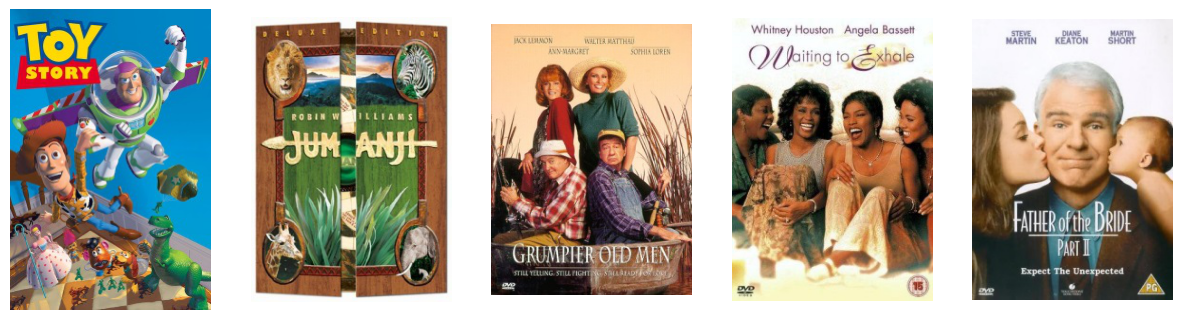

In [4]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Fetch images
movie_list = movies_metadata['imdb_id'].head(5).values

images = image_url(movie_list)

show_image(images)

# Movies that a user watched
### Will generate recommendations based on this

In [48]:
def user_watched(ratings, user, top_n):
    temp = ratings[(ratings['userId'] == user)].sort_values(by='timestamp',ascending=False)[:top_n]
    movie_list = temp['movieId'].values
    return movie_list

movie_list = user_watched(ratings, 1, 20)
movie_list


array([73017, 91500, 98809, 91542,   147,  4226,  1968, 69844, 81834,
       58559, 33794, 99114,  2959,  2918,  1246,  1221,   110,   858,
       59315, 68358], dtype=int64)

# Keywords Embedding Recommendation

In [15]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import ast


def keyword_similarity(keywords):
    # Load a fast sentence transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and fast!

    # Convert string representation of list to actual list
    keywords["keywords"] = keywords["keywords"].apply(ast.literal_eval)

    # Extract only the 'name' values
    keywords["keywords_list"] = keywords["keywords"].apply(lambda x: [d["name"] for d in x] if isinstance(x, list) else [])

    keywords['keywords_list'] = keywords['keywords_list'].apply(lambda x: ' '.join(x))

    # Encode movie keywords into embeddings
    keywords['vector'] = keywords['keywords_list'].apply(lambda x: model.encode(x))

    # Stack vectors for similarity computation
    movie_vectors = np.vstack(keywords['vector'].values)

    keyword_similarity_matrix = cosine_similarity(movie_vectors)

    return keyword_similarity_matrix

def keyword_rec(matrix, keywords, merge_df, movie, top_n = 10):
    keywords = keywords.merge(merge_df, left_on='id', right_on='tmdbId', how='left')
    movie_index = dict(zip(np.unique(keywords["movieId"]), list(range(keywords.shape[0]))))
    index_movie = dict(zip(list(range(keywords.shape[0])), np.unique(keywords["movieId"])))

    idx= movie_index[movie]
    similar_movies = list(enumerate(matrix[idx]))
    similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[1:top_n+1]
    similar_movie_list = [index_movie[i[0]] for i in similar_movies]

    # Fetch images
    movie_list = merge_df[merge_df['movieId'].isin(similar_movie_list)]['imdb_id'].values

    return movie_list

In [ ]:
keyword_similarity_matrix = keyword_similarity(keywords)
movie_list = keyword_rec(keyword_similarity_matrix, keywords, merged_df, 1, 10)

images = image_url(movie_list)
show_image(images)

# item-item recommendations with k-nn 
### Create user x movie matrix on ratings
**What movies were rated similarly by users?**

In [5]:
from scipy.sparse import csr_matrix
import numpy as np

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """

    # Number of unique users and movies to form matrix
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    # Map user/movie ID to an index (id, index)
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    # Map an index to a user/movie ID (index,id)
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    # list of unique indexes for users and movies
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    
    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [6]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    # Now it is movie x user by transposing it.
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

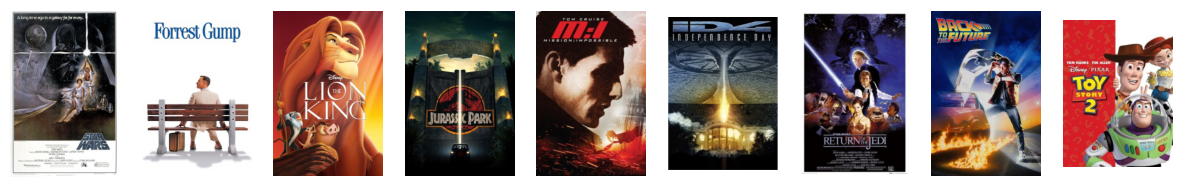

In [7]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

search = 1
similar_movies = find_similar_movies(search, X, movie_mapper, movie_inv_mapper, k=10)

# Fetch images
movie_list = merged_df[merged_df['movieId'].isin(similar_movies)]['imdb_id'].values

images = image_url(movie_list)
show_image(images)

# Purely based on genre
### One hot encoded movie x genre

In [14]:
import ast
from sklearn.metrics.pairwise import cosine_similarity

def genre_rec(merged_df, movie, top_n = 10):
    # Convert string representation of list to actual list
    try:
        merged_df["genres"] = merged_df["genres"].apply(ast.literal_eval)
    except:
        pass

    # Extract only the 'name' values
    merged_df["genres_list"] = merged_df["genres"].apply(lambda x: [d["name"] for d in x] if isinstance(x, list) else [])

    genres = set(g for G in merged_df["genres_list"] for g in G)
    df = merged_df[['movieId','genres_list']]

    for g in genres:
        df[g] = df.genres_list.transform(lambda x: int(g in x))

    df = df.reset_index(drop=True)
    movie_mapper = dict(zip(list(range(df.shape[0])), df["movieId"]))
    mapper_movie = dict(zip(df["movieId"], list(range(df.shape[0]))))
    movie_genres = df.drop(columns=['genres_list','movieId'])

    cosine_sim = cosine_similarity(movie_genres, movie_genres)

    idx = mapper_movie[movie]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(top_n+1)]
    similar_movies = [movie_mapper[i[0]] for i in sim_scores]

    return similar_movies

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\1341019018.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[g] = df.genres_list.transform(lambda x: int(g in x))
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\1341019018.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[g] = df.genres_list.transform(lambda x: int(g in x))
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\1341019018.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

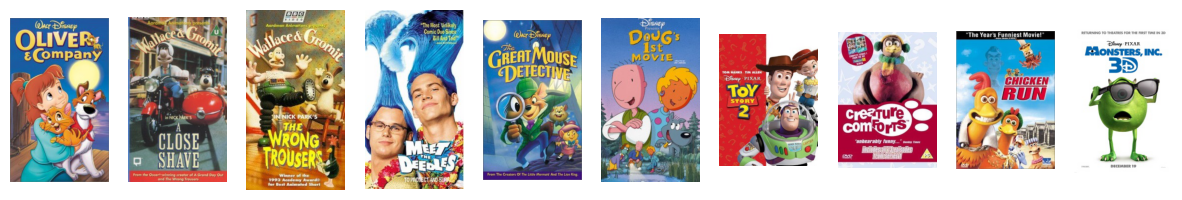

In [16]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Fetch images

similar_movies = genre_rec(merged_df, 1)

movie_list = merged_df[merged_df['movieId'].isin(similar_movies)]['imdb_id'].values

images = image_url(movie_list)

show_image(images)

# Users with similar taste also watch

In [17]:
import pandas as pd


def similar_user_movies(user, top_k, X):

    similar_users = find_similar_movies(user, X.T, user_mapper, user_inv_mapper, top_k)

    original_user_list = ratings[ratings['userId'] == 1]['movieId'].unique()

    similar_recommend = pd.DataFrame(
        ratings[
            (ratings['userId'].isin(similar_users)) & (~ratings['movieId'].isin(original_user_list))
        ]['movieId'].unique(), 
        columns=["movieId"]
    )

    return similar_recommend

similar_recommend = similar_user_movies(1, 10, X)

In [19]:
def nb_mean(ratings, meta):
    global_mean = ratings["rating"].mean()

    # Number of ratings per movie (n)
    movie_counts = ratings.groupby("movieId")["rating"].count()

    # Total rating sum per movie
    movie_rating_sums = ratings.groupby("movieId")["rating"].sum()

    # C: Average number of ratings per movie
    C = movie_counts.mean()

    # Compute Bayesian Mean for each movie
    bayesian_mean_ratings = (movie_rating_sums + global_mean * C) / (movie_counts + C)

    # Store results
    bayesian_mean_df = bayesian_mean_ratings.reset_index().rename(columns={"rating": "bayesian_mean"})

    bayesian_mean_df = bayesian_mean_df.merge(meta[['movieId','title']], on='movieId',how='left')

    return bayesian_mean_df

bayesian_mean_df = nb_mean(ratings, merged_df)

# New Releases

In [22]:
def new_releases(merged_df, ratings, top_n):
    # temp = merged_df[pd.to_datetime(merged_df['release_date']) >= pd.to_datetime('2017-07-01')][['movieId','release_date']].sort_values(by='release_date',ascending=False)
    release_ratings = ratings.merge(merged_df[['movieId','release_date','imdb_id']], on='movieId')
    recent_release = release_ratings[pd.to_datetime(release_ratings['release_date']) >= pd.to_datetime('2017-07-01')]
    recent_release["time_weight"] = (recent_release["timestamp"] - recent_release["timestamp"].min()) / (recent_release["timestamp"].max() - recent_release["timestamp"].min())

    # Apply an exponential decay function (e.g., exp(weight) to give more importance to recent_release recent_release)
    recent_release["time_weight"] = np.exp(recent_release["time_weight"])
    # Weighted sum of ratings per movie
    weighted_rating_sums = recent_release.groupby("imdb_id").apply(lambda x: np.sum(x["rating"] * x["time_weight"]))

    # Weighted count (sum of weights per movie)
    weighted_counts = recent_release.groupby("imdb_id")["time_weight"].sum()

    # Adjusted global mean with weighted ratings
    weighted_global_mean = np.sum(recent_release["rating"] * recent_release["time_weight"]) / np.sum(recent_release["time_weight"])


    # Number of ratings per movie (n)
    movie_counts = recent_release.groupby("imdb_id")["rating"].count()

    C = movie_counts.mean()

    # Compute Bayesian Mean with time-adjusted weighting
    time_weighted_bayesian_mean = (weighted_rating_sums + weighted_global_mean * C) / (weighted_counts + C)

    # Store results
    time_weighted_bayesian_recent_release = time_weighted_bayesian_mean.reset_index().rename(columns={0: "time_weighted_bayesian_mean"})

    movie_list = list(time_weighted_bayesian_recent_release.sort_values(by='time_weighted_bayesian_mean', ascending=False)['imdb_id'].head(top_n))

    return movie_list

test = new_releases(merged_df, ratings, 20)

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\374660797.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_release["time_weight"] = (recent_release["timestamp"] - recent_release["timestamp"].min()) / (recent_release["timestamp"].max() - recent_release["timestamp"].min())
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\374660797.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_release["time_weight"] = np.exp(recent_release["time_weight"])
C:\Users\JaeHoBahng\AppData\Local\Te

Failed to retrieve image from http://img.omdbapi.com/?i=tt5540188&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=tt6333058&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=tt5635086&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=tt4536768&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=tt1724597&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=tt6794380&apikey=49b60587


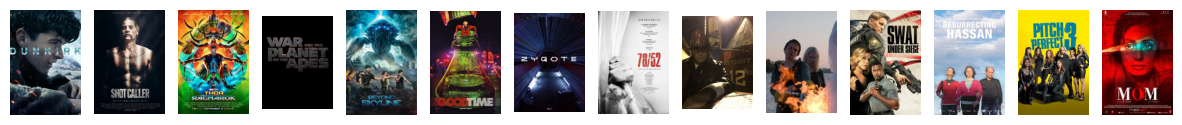

In [23]:
images = image_url(test)
show_image(images)

# Currently Trending

In [25]:
def currently_trending(ratings, meta, top_n):
    
    ratings["date"] = pd.to_datetime(ratings["timestamp"], unit="s").dt.date
    recent = ratings[ratings['date'] >= pd.Timestamp("2017-07-01").date()]
    recent["time_weight"] = (recent["timestamp"] - recent["timestamp"].min()) / (recent["timestamp"].max() - recent["timestamp"].min())
    # Apply an exponential decay function (e.g., exp(weight) to give more importance to recent recent)
    recent["time_weight"] = np.exp(recent["time_weight"])

    # Weighted sum of ratings per movie
    weighted_rating_sums = recent.groupby("movieId").apply(lambda x: np.sum(x["rating"] * x["time_weight"]))

    # Weighted count (sum of weights per movie)
    weighted_counts = recent.groupby("movieId")["time_weight"].sum()

    # Adjusted global mean with weighted ratings
    weighted_global_mean = np.sum(recent["rating"] * recent["time_weight"]) / np.sum(recent["time_weight"])


    # Number of ratings per movie (n)
    movie_counts = recent.groupby("movieId")["rating"].count()

    C = movie_counts.mean()

    # Compute Bayesian Mean with time-adjusted weighting
    time_weighted_bayesian_mean = (weighted_rating_sums + weighted_global_mean * C) / (weighted_counts + C)

    # Store results
    time_weighted_bayesian_recent = time_weighted_bayesian_mean.reset_index().rename(columns={0: "time_weighted_bayesian_mean"})

    a = time_weighted_bayesian_recent.sort_values(by='time_weighted_bayesian_mean', ascending=False).head(top_n)
    a = a.merge(meta[['movieId','imdb_id']],  on='movieId',how='left')
    movie_list = a['imdb_id'].values 

    return movie_list

movie_list = currently_trending(ratings, merged_df, 20)

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\3857012301.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent["time_weight"] = (recent["timestamp"] - recent["timestamp"].min()) / (recent["timestamp"].max() - recent["timestamp"].min())
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\3857012301.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent["time_weight"] = np.exp(recent["time_weight"])
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\3857012301.py:10: DeprecationWarnin

Failed to retrieve image from http://img.omdbapi.com/?i=tt3718778&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=nan&apikey=49b60587


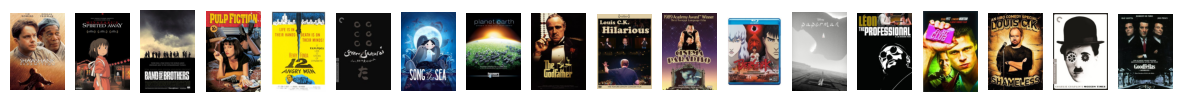

In [26]:
images = image_url(movie_list)
show_image(images)

# Best alltime

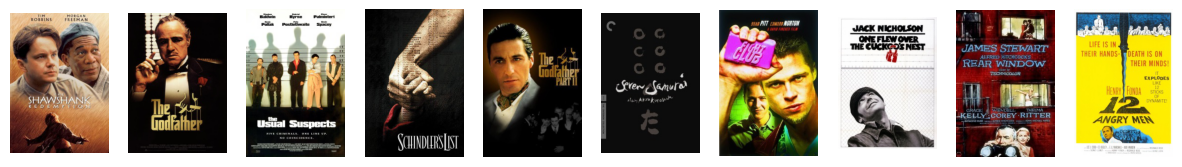

In [30]:
import pandas as pd

def best_alltime(ratings, meta, top_n):

    # Global mean rating (m)
    global_mean = ratings["rating"].mean()

    # Number of ratings per movie (n)
    movie_counts = ratings.groupby("movieId")["rating"].count()

    # Total rating sum per movie
    movie_rating_sums = ratings.groupby("movieId")["rating"].sum()

    # C: Average number of ratings per movie
    C = movie_counts.mean()

    # Compute Bayesian Mean for each movie
    bayesian_mean_ratings = (movie_rating_sums + global_mean * C) / (movie_counts + C)

    # Store results
    bayesian_mean_df = bayesian_mean_ratings.reset_index().rename(columns={"rating": "bayesian_mean"})

    a = bayesian_mean_df.sort_values(by='bayesian_mean', ascending=False).head(top_n)
    a = a.merge(meta[['movieId','imdb_id']],  on='movieId',how='left')
    movie_list = a['imdb_id'].values 

    return movie_list

images_list = best_alltime(ratings, merged_df, 10)
images = image_url(images_list)
show_image(images)